In [1]:
%load_ext cython
import speckle_tracking as st
import st_sim
from st_sim.bin import *
import h5py
import os
import numpy as np
import pickle
import concurrent.futures
import matplotlib.pyplot as plt
from multiprocessing import cpu_count
from scipy.ndimage import gaussian_filter, convolve1d
from scipy.integrate import quad
from scipy.optimize import least_squares

In [2]:
def st_update(I_n, W, dij, basis, x_ps, y_ps, z, df, u_max=100, n_iter=5):
    """
    Andrew's speckle tracking update algorithm
    
    I_n - measured data
    W - whitefield
    basis - detector plane basis vectors
    x_ps, y_ps - x and y pixel sizes
    z - distance between the sample and the detector
    df - defocus distance
    u_max - pixel mapping search window size
    n_iter - number of iterations
    """
    M = np.ones((I_n.shape[1], I_n.shape[2]), dtype=bool)
    u, dij_pix, res = st.generate_pixel_map(W.shape, dij, basis, x_ps,
                                            y_ps, z, df, verbose=False)
    I0, n0, m0 = st.make_object_map(I_n, M, W, dij_pix, u, subpixel=True, verbose=False)

    es = []
    for i in range(n_iter):

        # calculate errors
        error_total = st.calc_error(I_n, M, W, dij_pix, I0, u, n0, m0, subpixel=True, verbose=False)[0]

        # store total error
        es.append(error_total)

        # update pixel map
        u = st.update_pixel_map(I_n, M, W, I0, u, n0, m0, dij_pix,
                                search_window=[1, u_max], subpixel=True,
                                fill_bad_pix=True, integrate=False,
                                quadratic_refinement=True, verbose=False)[0]
        u_max = int(np.max(np.abs(u - np.indices(W.shape))))

        # make reference image
        I0, n0, m0 = st.make_object_map(I_n, M, W, dij_pix, u, subpixel=True, verbose=False)

        # update translations
        dij_pix = st.update_translations(I_n, M, W, I0, u, n0, m0, dij_pix)[0]
    return {'u':u, 'I0':I0, 'errors':es}

def pixel_translations(basis, dij, df, z):
    dij_pix = (basis * dij[:, None]).sum(axis=-1)
    dij_pix /= (basis**2).sum(axis=-1) * df / z
    dij_pix -= dij_pix.mean(axis=0)
    return np.ascontiguousarray(dij_pix[:, 0]), np.ascontiguousarray(dij_pix[:, 1])

def str_update(I_n, W, dij, basis, x_ps, y_ps, z, df, u_max=100, n_iter=5, l_scale=2.5):
    """
    Robust version of Andrew's speckle tracking update algorithm
    
    I_n - measured data
    W - whitefield
    basis - detector plane basis vectors
    x_ps, y_ps - x and y pixel sizes
    z - distance between the sample and the detector
    df - defocus distance
    u_max - pixel mapping search window size
    n_iter - number of iterations
    """
    I_n = I_n.astype(np.float64)
    W = W.astype(np.float64)
    u = np.indices(W.shape, dtype=np.float64)
    di, dj = pixel_translations(basis, dij, df, z)
    dss, dfs = np.mean(di[1:] - di[:-1]), np.mean(dj[1:] - dj[:-1])
    I0, di, dj = make_reference(I_n, W, u, di, dj, l_scale)

    es = []
    for i in range(n_iter):

        # calculate errors
        es.append(total_mse(I_n, W, I0, u, di, dj))

        # update pixel map
        u = update_pixel_map_search(I_n, W, I0, u, di, dj, dss, dfs, 1, u_max // 2)
        u_max = int(np.max(np.abs(u - np.indices(W.shape))))
        u = gaussian_filter(u, (0, 0, l_scale))

        # make reference image
        I0, di, dj = make_reference(I_n, W, u, di, dj, l_scale)
    return {'u':u, 'I0':I0, 'errors':es}

In [3]:
def ab_model(pix, coeff):
    return coeff[0] + coeff[1] * (pix - coeff[3]) + coeff[2] * (pix - coeff[3])**2

def ab_errors(coeff, data, weights):
    return weights * (ab_model(data[:, 0], coeff) - data[:, 1])

def ph_model(theta, coeff):
    return coeff[0] + coeff[1] * (theta - coeff[4]) + \
           coeff[2] * (theta - coeff[4])**2 + coeff[3] * (theta - coeff[4])**3

def ph_errors(coeff, data):
    return ph_model(data[:, 0], coeff) - data[:, 1]

def phase_fit(u, roi, x_ps, z, df, wl, u_var=1e-6, l_scale=5, max_order=4):
    # calculate the phase
    u_pix = (u - np.indices((u.shape[1], u.shape[2])))[1, 0, roi[0]:roi[1]]
    ang = u_pix * x_ps / z
    phase = np.cumsum(ang) * x_ps * df / z * 2 * np.pi / wl
    pix = np.arange(u.shape[2])[roi[0]:roi[1]]
    x, theta = pix * x_ps, pix * x_ps / z

    data = np.stack((pix, gaussian_filter(u_pix, l_scale)), axis=-1)
    w = np.tanh(data[:, 1]**2 / u_var)

    # find a min/max argument
    u0 = gaussian_filter(u_pix, u_pix.shape[0] / 10)
    if np.median(np.gradient(np.gradient(u0))) > 0:
        idx = np.argmin(u0)
    else:
        idx = np.argmax(u0)

        
    # fit the model to the data
    bounds = ([-np.inf, -np.inf, -np.inf, 0],
              [np.inf, np.inf, np.inf, u_pix.shape[0]])
    fit = least_squares(ab_errors, np.array([0, 0, 0, pix[idx]]), args=(data, w),
                          xtol=1e-14, ftol=1e-14, bounds=bounds, loss='cauchy')
    ang_fit = np.array([fit.x[0], fit.x[1] / (x_ps / z),
                        fit.x[2] / (x_ps / z)**2, fit.x[3]]) * x_ps / z
    ph_fit = np.array([0, ang_fit[0], ang_fit[1] / 2, ang_fit[2] / 3]) * 2 * np.pi / wl * df
    ph_fit = np.concatenate((ph_fit, [ang_fit[-1]]))
    phase -= np.mean(phase - ph_model(theta, ph_fit))

    # evaluating errors
    r_sq = 1 - np.sum(ab_errors(fit.x, data, w)**2) / np.sum((w * (data[:, 1] - data[:, 1].mean()))**2)
    return {'pix': pix, 'theta': theta, 'u_pix': u_pix, 'angles': ang, 'phase': phase,
            'fit': fit, 'ang_fit': ang_fit, 'ph_fit': ph_fit, 'r_sq': r_sq}

# dev

In [5]:
%%cython -c=-fopenmp -lgsl -lgslcblas -lomp -L=/usr/local/lib
#cython: language_level=3, boundscheck=False, wraparound=False, initializedcheck=False, cdivision=True
cimport numpy as cnp
import numpy as np
cimport openmp
from cython_gsl cimport *
from libc.math cimport sqrt, cos, sin, exp, pi, erf, sinh, floor
from cython.parallel import prange, parallel

ctypedef cnp.complex128_t complex_t
ctypedef cnp.float64_t float_t
ctypedef cnp.int64_t int_t
ctypedef cnp.uint64_t uint_t
ctypedef cnp.uint8_t uint8_t
DEF X_TOL = 4.320005384913445 # Y_TOL = 1e-9
DEF FLOAT_MAX = 1.7976931348623157e+308

cdef int_t binary_search(float_t[::1] values, int_t l, int_t r, float_t x) nogil:
    cdef int_t m = l + (r - l) // 2
    if l <= r:
        if x == values[m]:
            return m
        elif x > values[m] and x <= values[m + 1]:
            return m + 1
        elif x < values[m]:
            return binary_search(values, l, m, x)
        else:
            return binary_search(values, m + 1, r, x)

cdef int_t searchsorted(float_t[::1] values, float_t x) nogil:
    cdef int_t r = values.shape[0]
    if x < values[0]:
        return 0
    elif x > values[r - 1]:
        return r
    else:
        return binary_search(values, 0, r, x)

cdef void barcode_c(float_t[::1] br_tr, float_t[::1] x_arr, float_t[::1] bx_arr,
                     float_t sgm, float_t atn, float_t step) nogil:
    cdef:
        int_t a = x_arr.shape[0], b = bx_arr.shape[0], i, j0, j
        float_t br_dx = (bx_arr[b - 1] - bx_arr[0]) / b
        int_t bb = <int_t>(X_TOL * sqrt(2) * sgm / br_dx + 1)
        float_t tr, xx, x0, x1
    for i in range(a):
        xx = x_arr[i] - x_arr[0] + step
        j0 = searchsorted(bx_arr, xx) # even '-', odd '+'
        tr = 0
        for j in range(j0 - bb, j0 + bb + 1):
            if j >= 1 and j < b:
                x0 = (xx - bx_arr[j - 1]) / sqrt(2) / sgm
                x1 = (xx - bx_arr[j]) / sqrt(2) / sgm
                tr += 0.5 * (0.5 - j % 2) * (erf(x0) - erf(x1))
        tr -= 0.25 * erf((xx - bx_arr[0]) / sqrt(2) / sgm)
        tr += 0.25 * erf((xx - bx_arr[b - 1]) / sqrt(2) / sgm)
        br_tr[i] = sqrt(1 + atn * tr)

def barcode_1d(float_t[::1] x_arr, float_t[::1] bx_arr, float_t sgm, float_t atn):
    """
    Barcode transmission array for a scan

    x_arr - coordinates [um]
    bx_arr - bar coordinates array [um]
    sgm - bar haziness width [um]
    atn - bar attenuation (0.0 - 1.0)
    ss - scan step size [um]
    nf - number of frames of a scan
    """
    cdef:
        int_t a = x_arr.shape[0]
        float_t[::1] br_tr = np.empty(a, dtype=np.float64)
    barcode_c(br_tr, x_arr, bx_arr, sgm, atn, 0)
    return np.asarray(br_tr)
        
def barcode_2d(float_t[::1] x_arr, float_t[::1] bx_arr, float_t sgm, float_t atn, float_t ss, int_t nf):
    """
    Barcode transmission array for a scan

    x_arr - coordinates [um]
    bx_arr - bar coordinates array [um]
    sgm - bar haziness width [um]
    atn - bar attenuation (0.0 - 1.0)
    ss - scan step size [um]
    nf - number of frames of a scan
    """
    cdef:
        int_t a = x_arr.shape[0], i
        float_t[:, ::1] br_tr = np.empty((nf, a), dtype=np.float64)
    for i in range(nf):
        barcode_c(br_tr[i], x_arr, bx_arr, sgm, atn, i * ss)
    return np.asarray(br_tr)

cdef float_t bprd_varc(float_t br_dx, float_t sgm, float_t atn) nogil:
    cdef:
        int_t a = <int_t>(br_dx / sgm + 1), i, n
        float_t var = 0
    for i in range(-a, a):
        n = 1 + 2 * i
        var += (atn * sin(pi * n / 2)**2 / pi / n)**2 * exp(-(pi * sgm * n / br_dx)**2)
    return var

cdef float_t bnprd_varc(float_t br_dx, float_t sgm, float_t atn) nogil:
    cdef:
        float_t br_rt = br_dx / 2 / sgm
        float_t exp_term = 4 * exp(-br_rt**2 / 4) - exp(-br_rt**2) - 3
    return atn**2 / 4 * (2 * erf(br_rt / 2) - erf(br_rt) + exp_term / sqrt(pi) / br_rt)

def bprd_var(float_t br_dx, float_t[::1] sgm_arr, float_t atn):
    cdef:
        int_t a = sgm_arr.shape[0], i
        float_t[::1] var_arr = np.empty(a, dtype=np.float64)
    for i in range(a):
        var_arr[i] = bprd_varc(br_dx, sgm_arr[i], atn)
    return np.asarray(var_arr)

def bnprd_var(float_t br_dx, float_t[::1] sgm_arr, float_t atn):
    cdef:
        int_t a = sgm_arr.shape[0], i
        float_t[::1] var_arr = np.empty(a, dtype=np.float64)
    for i in range(a):
        var_arr[i] = bnprd_varc(br_dx, sgm_arr[i], atn)
    return np.asarray(var_arr)

In [6]:
params = st_sim.parameters(bar_size = 1, bar_sigma = 0.1, attenuation=0.25, p0 = 7e3)

globals().update(**params.export_dict())
print(params)

{'defoc': 400.0, 'det_dist': 2000000.0, 'step_size': 0.1, 'n_frames': 300, 'fs_size': 2000, 'ss_size': 1000, 'pix_size': 55.0, 'p0': 7000.0, 'wl': 7.29e-05, 'th_s': 0.0002, 'ap_x': 40.0, 'ap_y': 2.0, 'focus': 1500.0, 'alpha': -0.05, 'bar_size': 1, 'bar_sigma': 0.1, 'attenuation': 0.25, 'random_dev': 0.6, 'verbose': False}


In [488]:
n_x = int(1.6 * ap_x / focus * defoc * fs_size * pix_size / wl / det_dist)
n_y = int(1.2 * ap_y * ss_size * pix_size / wl / det_dist)
x_arr = np.linspace(-0.8 * ap_x / focus * defoc, 0.8 * ap_x / focus * defoc, n_x)
y_arr = np.linspace(-0.6 * ap_y, 0.6 * ap_y, n_y)
xx_arr = pix_size * np.arange(-fs_size // 2, fs_size // 2)
yy_arr = pix_size * np.arange(-ss_size // 2, ss_size // 2)

In [489]:
wf0_x = lens(x_arr, wl, ap_x, focus, defoc, alpha)
wf0_y = aperture(y_arr, focus + defoc, wl, ap_y)
wf1_y = fraunhofer_1d(wf0_y, y_arr, yy_arr, det_dist, wl)
print(n_x, n_y)

12876 905


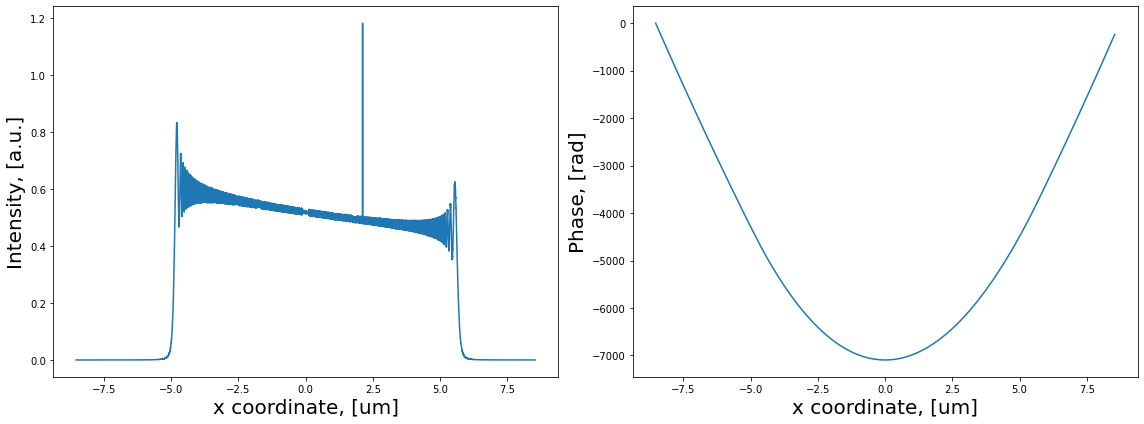

In [490]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(x_arr, np.abs(wf0_x)**2)
axes[0].set_ylabel('Intensity, [a.u.]', fontsize=20)
axes[1].plot(x_arr, np.unwrap(np.angle(wf0_x)))
axes[1].set_ylabel('Phase, [rad]', fontsize=20)
for ax in axes:
    ax.set_xlabel('x coordinate, [um]', fontsize=20)
plt.tight_layout(h_pad=0.2)
plt.show()
# plt.savefig('figures/wf0_x.pdf')

In [491]:
fx_lim = np.array([-0.45 * ap_x / focus, 0.5 * ap_x / focus])
th_lim = fx_lim - wl / 2 / np.pi * alpha * 3e9 * fx_lim**2 / defoc
print(th_lim * defoc)

[-4.54938826  5.64273054]


In [492]:
beam_span = np.clip(th_lim * defoc, x_arr[0], x_arr[-1])
wf0_roi = ((beam_span - x_arr[0]) // (x_arr[1] - x_arr[0])).astype(np.int)
xr_arr = x_arr[wf0_roi[0]:wf0_roi[1]]
wf0_ph = np.unwrap(np.angle(wf0_x))
wf0_ph_fc = np.polyfit(xr_arr, wf0_ph[wf0_roi[0]:wf0_roi[1]], 3)
df_fit = np.pi / wl / wf0_ph_fc[1]
alpha_fit = wf0_ph_fc[0] * df_fit**3 * 1e-9
wf0_ph_fit = np.pi * xr_arr**2 / wl / df_fit + alpha_fit * 1e9 * (xr_arr / df_fit)**3 + wf0_ph[np.searchsorted(x_arr, 0)]
wf0_ph_th = np.pi * xr_arr**2 / wl / defoc + alpha * 1e9 * (xr_arr / defoc)**3 + wf0_ph[np.searchsorted(x_arr, 0)]
print(df_fit, alpha_fit)

398.77099543001054 -0.048130831073207495


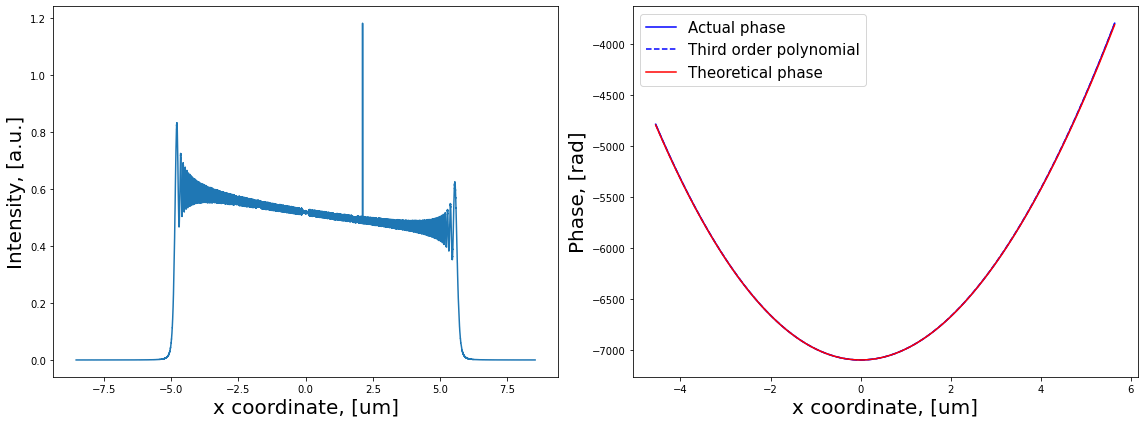

In [493]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(x_arr, np.abs(wf0_x)**2)
axes[0].set_ylabel('Intensity, [a.u.]', fontsize=20)
axes[1].plot(xr_arr, wf0_ph[wf0_roi[0]:wf0_roi[1]], label='Actual phase', color='b')
axes[1].plot(xr_arr, wf0_ph_fit, color='b', label='Third order polynomial', linestyle='dashed')
axes[1].plot(xr_arr, wf0_ph_th, color='r', label='Theoretical phase')
axes[1].set_ylabel('Phase, [rad]', fontsize=20)
axes[1].legend(fontsize=15)
for ax in axes:
    ax.set_xlabel('x coordinate, [um]', fontsize=20)
plt.tight_layout(h_pad=0.2)
plt.show()
# plt.savefig('figures/wf0_phase_2.pdf')

In [494]:
bsteps = barcode_steps(x_arr[-1] - x_arr[0], bar_size, random_dev, step_size, n_frames)
bs_t = barcode_2d(x_arr, bsteps, bar_sigma, attenuation, step_size, n_frames)
wf1_x = fraunhofer_2d(wf0_x * bs_t, x_arr, xx_arr, det_dist, wl)

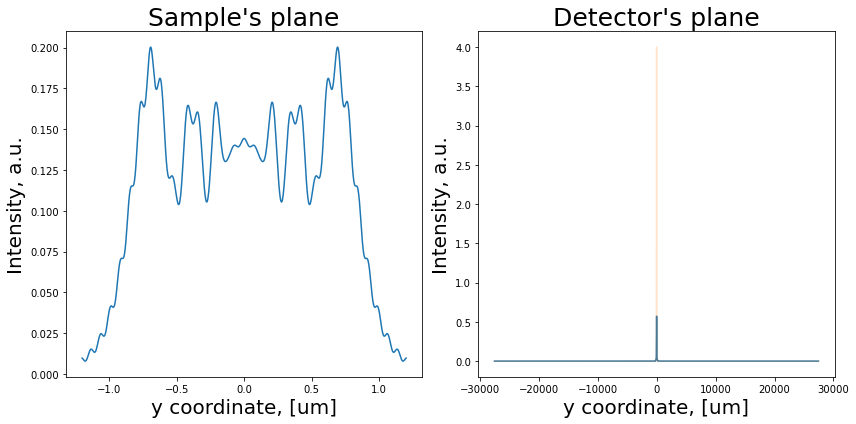

In [495]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].plot(y_arr, np.abs(wf0_y)**2)
axes[1].plot(yy_arr, np.abs(wf1_y)**2)
axes[1].plot(yy_arr, (ap_y * np.sinc(np.pi * ap_y * yy_arr / wl / (det_dist + focus + defoc)))**2, alpha=0.2)
axes[0].set_title("Sample's plane", fontsize=25)
axes[1].set_title("Detector's plane", fontsize=25)
for ax in axes:
    ax.set_xlabel('y coordinate, [um]', fontsize=20)
    ax.set_ylabel('Intensity, a.u.', fontsize=20)
plt.tight_layout(w_pad=1.)
plt.show()
# plt.savefig('figures/beam_x.pdf')

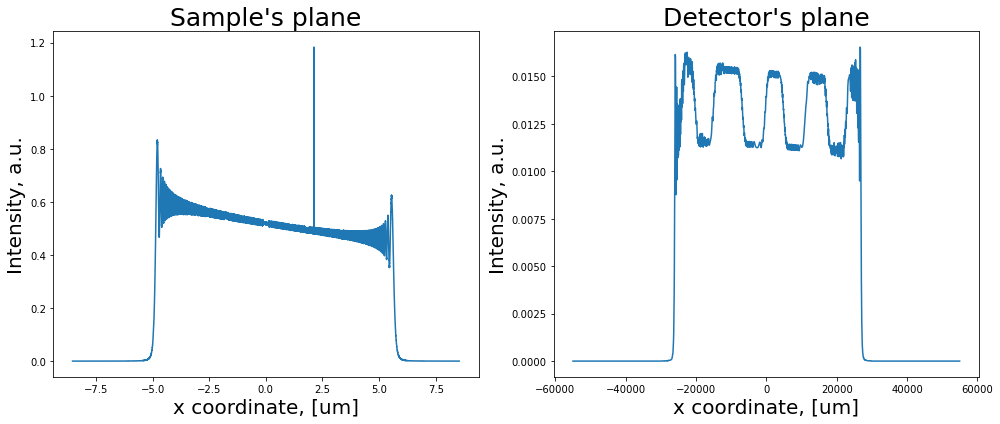

In [496]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].plot(x_arr, np.abs(wf0_x)**2)
axes[1].plot(xx_arr, np.abs(wf1_x[10])**2)
axes[0].set_title("Sample's plane", fontsize=25)
axes[1].set_title("Detector's plane", fontsize=25)
for ax in axes:
    ax.set_xlabel('x coordinate, [um]', fontsize=20)
    ax.set_ylabel('Intensity, a.u.', fontsize=20)
plt.tight_layout(w_pad=1.)
plt.show()
# plt.savefig('figures/beam_x.pdf')

In [497]:
fx_lim = np.array([-0.5 * ap_x / focus, 0.5 * ap_x / focus])
th_lim = fx_lim - wl / 2 / np.pi * alpha * 3e9 * fx_lim**2 / (det_dist + defoc)
pdet = p0 * (1 - attenuation / 2) 
ppix = pdet * pix_size / (np.tan(th_lim)[1] - np.tan(th_lim)[0]) / (det_dist + defoc)
print(ppix)

6.314768986210761


In [498]:
sigma = th_s * defoc
sx_arr = pix_size * np.arange(-np.ceil(4 * sigma / pix_size), np.ceil(4 * sigma / pix_size) + 1)
s_arr = np.exp(-sx_arr**2 / 2 / sigma**2)
s_arr /= s_arr.sum()

In [499]:
det_c = 1 / wl**2 / (focus + defoc) / det_dist
i0 = p0 / ap_x / ap_y
data = make_frames(i_x=i0 * np.abs(wf1_x * det_c)**2, i_y=(np.abs(wf1_y)**2).sum() * np.ones(1),
                   sc_x=s_arr, sc_y=np.ones(1), pix_size=pix_size)
beam_span = np.tan(th_lim) * (det_dist + defoc)
x_roi = np.clip((beam_span - xx_arr.min()) // pix_size, 0, fs_size).astype(np.int)
roi = (data.shape[1] // 2, data.shape[1] // 2 + 1, x_roi[0], x_roi[1])
ptych = data[:, :, roi[2]:roi[3]].sum(axis=1)
mask = np.ones((data.shape[1], data.shape[2]), dtype=np.uint8)
whitefield = make_whitefield(data, mask)
print(data.shape, np.mean(ptych[..., 20:-20]), np.std(ptych[..., 20:-20]),
      np.std(ptych[..., 20:-20]) / np.sqrt(np.mean(ptych[..., 20:-20])))

(300, 1, 2000) 6.182084678866165 2.608659607396254 1.0491798444211506


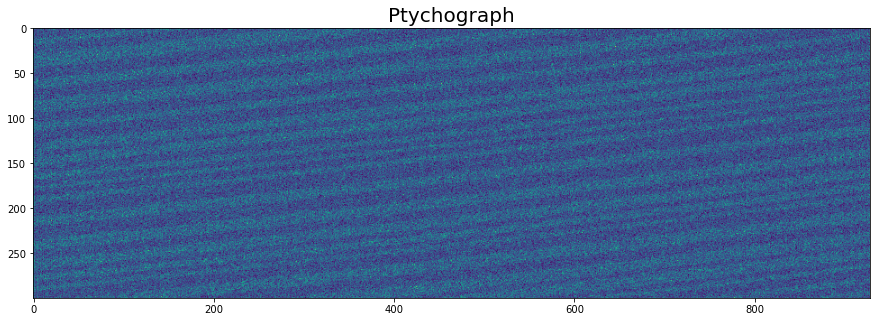

In [500]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(15, 6))
ax.imshow(ptych[..., 20:-20])
ax.set_title('Ptychograph', fontsize=20)
plt.show()

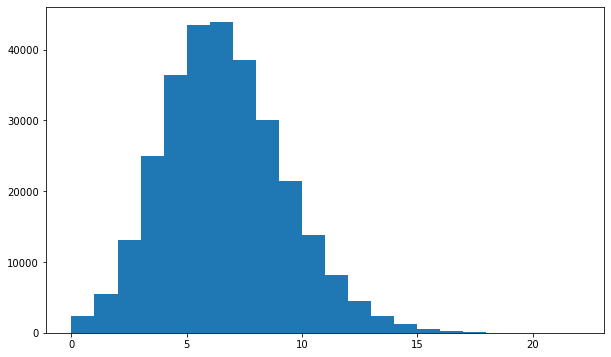

In [501]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(ptych.ravel(), min(int(ptych.max() - ptych.min()), 100))
plt.show()

In [502]:
st_params = st_sim.STParams.import_dict(**globals())
ini_parser = st_params.export_ini()
with open('results/test/parameters.ini', 'w') as file:
    ini_parser.write(file)
    
st_converter = st_sim.STConverter()
st_converter.save(data, st_params, 'results/test', roi=roi)

# st_sim

In [18]:
st_loader = st_sim.loader()
st_data = st_loader.load('results/test/data.cxi')
st_data = st_data.change_defocus(0.00042)
st_1d = st_data.st_process().crop_data([0, 1, 50, 969])
st_res, errors = st_1d.iter_update(wfs=200, n_iter=5, l_scale=6.)

Iteration No. 1: MSE = 0.92891
Iteration No. 1: Search window size = 38
Iteration No. 2: MSE = 0.91080
Iteration No. 2: Search window size = 40
Iteration No. 3: MSE = 0.91019
Iteration No. 3: Search window size = 41
Iteration No. 4: MSE = 0.91017
Iteration No. 4: Search window size = 41
Iteration No. 5: MSE = 0.91017
Iteration No. 5: Search window size = 41


In [15]:
st_1d.data.shape, st_1d.

(298, 1, 969)

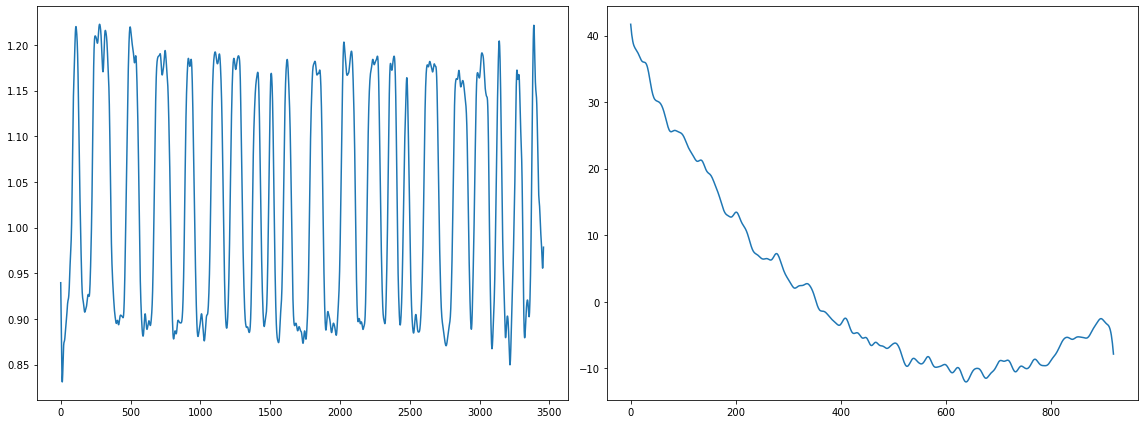

In [19]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(st_res.ref_img[0])
axes[1].plot((st_res.pix_map - np.indices(st_res.whitefield.shape))[1, 0])
plt.tight_layout()
plt.show()

In [9]:
data_dir = 'results/test'
with h5py.File(os.path.join(data_dir, 'data.cxi'), 'r') as cxi_file:
    roi = cxi_file['/speckle_tracking/roi'][...]
    I_n = cxi_file['/entry_1/data_1/data'][:, :, roi[2]:roi[3]].sum(axis=1)[:, None]
    M = cxi_file['/speckle_tracking/mask'][roi[0]:roi[1], roi[2]:roi[3]]
    W = cxi_file['/speckle_tracking/whitefield'][roi[0]:roi[1], roi[2]:roi[3]]
    basis = cxi_file['/entry_1/instrument_1/detector_1/basis_vectors'][...]
    z = cxi_file['/entry_1/instrument_1/detector_1/distance'][...]
    x_ps = cxi_file['/entry_1/instrument_1/detector_1/x_pixel_size'][...]
    y_ps = cxi_file['/entry_1/instrument_1/detector_1/y_pixel_size'][...]
    wl = cxi_file['/entry_1/instrument_1/source_1/wavelength'][...]
    dij = cxi_file['/entry_1/sample_1/geometry/translations'][...]
    df = cxi_file['/speckle_tracking/defocus'][...]

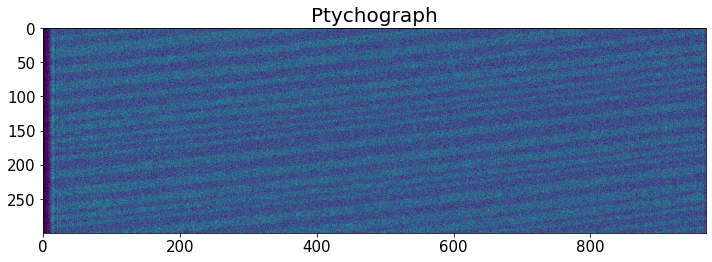

In [10]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(I_n[:, 0])
ax.set_title('Ptychograph', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
plt.show()
# plt.savefig('figures/ptycho.pdf')

In [14]:
params = st_sim.parameters()

fx = params.ap_x / 2 / params.focus
z_bar = params.defoc * params.det_dist / (params.defoc + params.det_dist)
th_max = abs(params.wl / 2 / np.pi * params.alpha * 3e9 * fx**2 / (params.defoc + z_bar))
sw_max = max(int(2 * th_max / params.pix_size * params.det_dist), 10)
print(sw_max, th_max)

28 0.00038678518249739865


In [15]:
#---------------------------
# Initialise
#---------------------------

# generate pixel map
u, dij_pix, res = st.generate_pixel_map(W.shape, dij, basis, x_ps, y_ps, z, df, verbose=False)
di, dj = pixel_translations(basis, dij, df, z)

# make reference image
I0, n0, m0 = st.make_object_map(I_n, M, W, dij_pix, u, subpixel=True)

I0_gk, di, dj = make_reference(I_n.astype(np.float64), W.astype(np.float64), u, di, dj, ls=8.)

building object map: 100%|██████████| 300/300 [00:00<00:00, 3493.12it/s]


In [16]:
K = I_n.shape[-1] / (dij_pix[0, 1] - dij_pix[1, 1])
N = I_n.shape[0]
dI0 = np.gradient(I0_gk[0])
dI0_avg = np.mean(dI0**2)
p_var = np.mean(I_n)
print(np.sqrt((p_var / N + p_var / N / K) / dI0_avg / np.mean(I_n**2)))
# print(np.median((ph_res['u_pix'] - gaussian_filter(ph_res['u_pix'], 20))**2)**0.5)

4.896835718301136


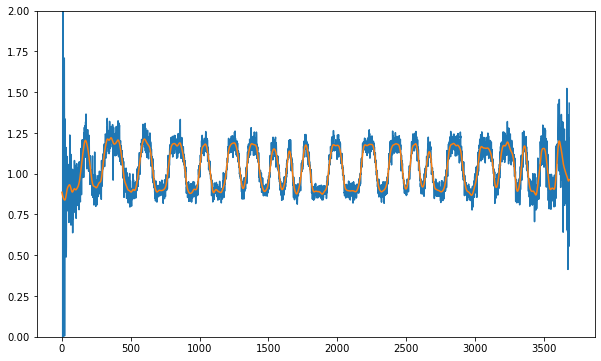

In [17]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(I0[0])
ax.plot(I0_gk[0])
ax.set_ylim(0, 2)
plt.show()

In [200]:
st_res = st_update(I_n, W, dij, basis, x_ps, y_ps, z, df)
ph_res = phase_fit(st_res['u'], (50, I_n.shape[-1] - 50), x_ps, z, df, wl)

updating object map and translations: 2.65e+02:   0%|          | 0/100 [00:00<?, ?it/s]


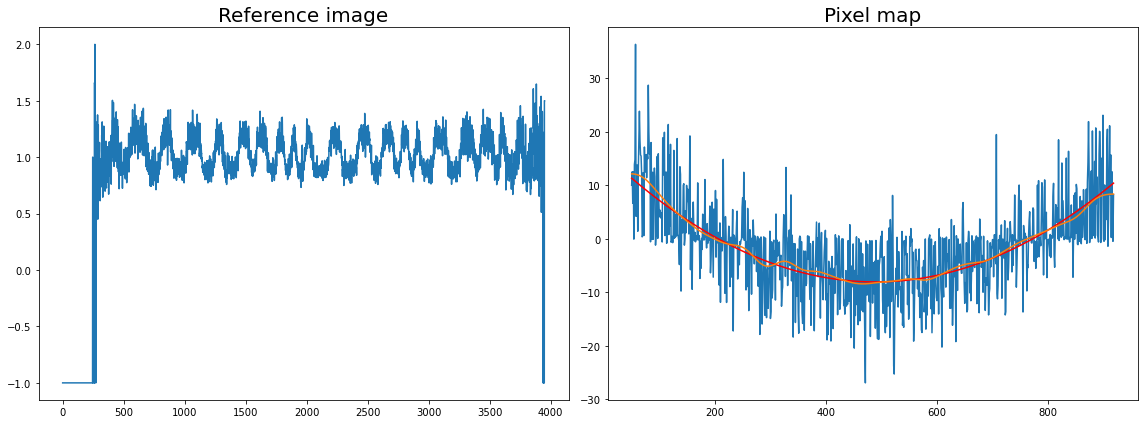

In [201]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(st_res['I0'][0])
axes[0].set_title('Reference image', fontsize=20)
axes[1].plot(ph_res['pix'], ph_res['u_pix'])
axes[1].plot(ph_res['pix'], ab_model(ph_res['pix'], ph_res['fit'].x), color='red')
axes[1].plot(ph_res['pix'], gaussian_filter(ph_res['u_pix'], 20))
axes[1].set_title('Pixel map', fontsize=20)
plt.tight_layout()
plt.show()
# plt.savefig('figures/st_results_simold.pdf')

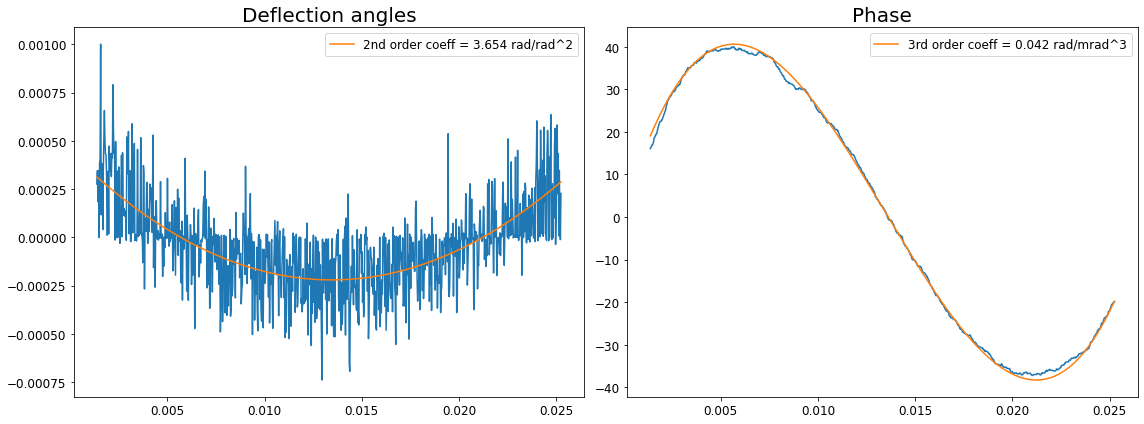

In [202]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(ph_res['theta'], ph_res['angles'])
axes[0].plot(ph_res['theta'], ab_model(ph_res['theta'], ph_res['ang_fit']),
             label='2nd order coeff = {:.3f} rad/rad^2'.format(ph_res['ang_fit'][2]))
axes[0].set_title('Deflection angles', fontsize=20)
axes[1].plot(ph_res['theta'], ph_res['phase'])
axes[1].plot(ph_res['theta'], ph_model(ph_res['theta'], ph_res['ph_fit']),
             label='3rd order coeff = {:.3f} rad/mrad^3'.format(ph_res['ph_fit'][3] * 1e-9))
axes[1].set_title('Phase', fontsize=20)
for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.legend(fontsize=12)
plt.tight_layout()
plt.show()
# plt.savefig('figures/st_fits_simold.pdf')

In [14]:
str_res = str_update(I_n, W, dij, basis, x_ps, y_ps, z, df)
phr_res = phase_fit(str_res['u'], (0, I_n.shape[-1]), x_ps, z, df, wl)

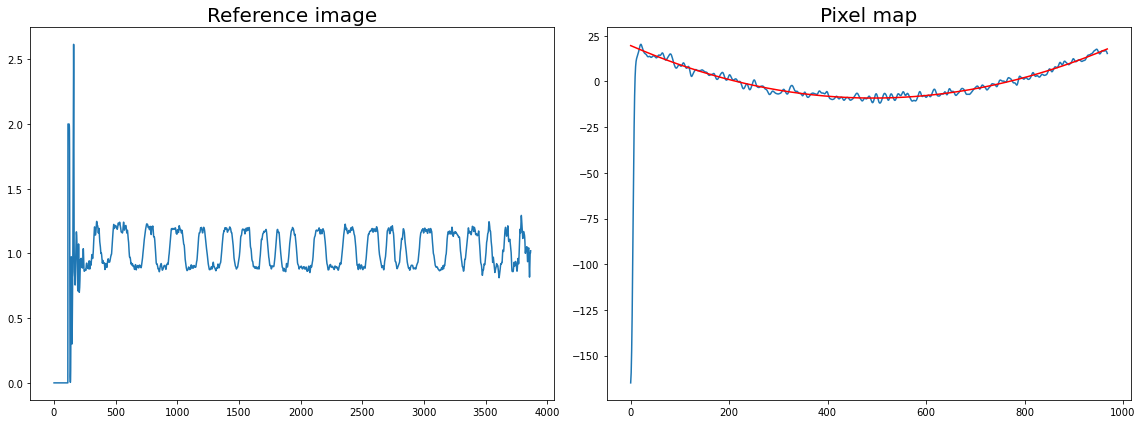

In [15]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(str_res['I0'][0])
axes[0].set_title('Reference image', fontsize=20)
axes[1].plot(phr_res['pix'], phr_res['u_pix'])
axes[1].plot(phr_res['pix'], ab_model(phr_res['pix'], phr_res['fit'].x), color='red')
axes[1].set_title('Pixel map', fontsize=20)
plt.tight_layout()
plt.show()
# plt.savefig('figures/st_results_simnew.pdf')

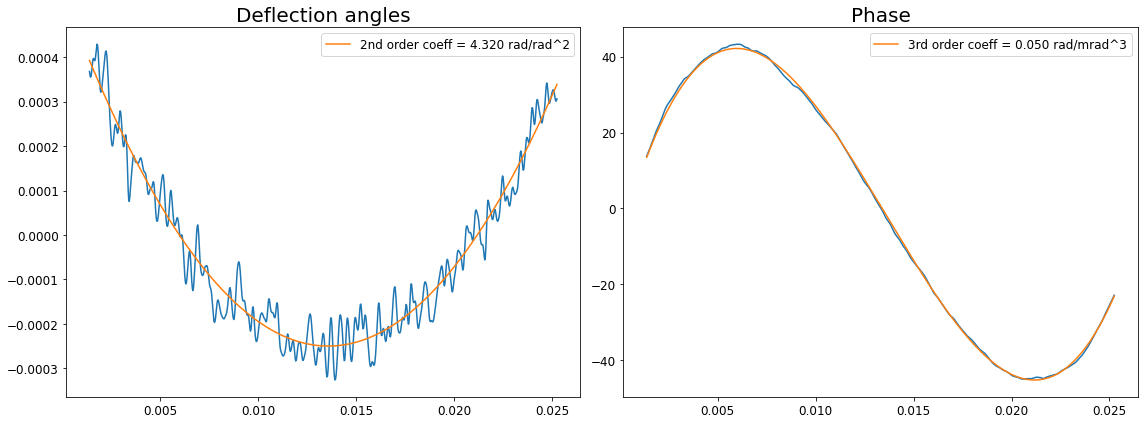

In [132]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(phr_res['theta'], phr_res['angles'])
axes[0].plot(phr_res['theta'], ab_model(phr_res['theta'], phr_res['ang_fit']),
             label='2nd order coeff = {:.3f} rad/rad^2'.format(phr_res['ang_fit'][2]))
axes[0].set_title('Deflection angles', fontsize=20)
axes[1].plot(phr_res['theta'], phr_res['phase'])
axes[1].plot(phr_res['theta'], ph_model(phr_res['theta'], phr_res['ph_fit']),
             label='3rd order coeff = {:.3f} rad/mrad^3'.format(phr_res['ph_fit'][3] * 1e-9))
axes[1].set_title('Phase', fontsize=20)
for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.legend(fontsize=12)
plt.tight_layout()
plt.show()
# plt.savefig('figures/st_fits_simnew.pdf')

# Experiment results

In [5]:
u_dict, o_dict, ph_dict, th_dict = {}, {}, {}, {}
uf_dict, phf_dict, data_dict, r_dict = {}, {}, {}, {}

In [177]:
roi_dict = {1511: (0, 1, 340, 1230), 1512: (0, 1, 340, 1230), 1513: (0, 1, 340, 1230), 1595: (0, 1, 360, 1050),
            1596: (0, 1, 360, 1050), 1597: (0, 1, 360, 1050), 1598: (0, 1, 360, 1050), 1654: (0, 1, 360, 1050),
            1670: (0, 1, 300, 1440), 1723: (0, 1, 370, 1195), 1727: (0, 1, 370, 1195)}
filename = 'Scan_{:d}.cxi'
exp_dir = 'results/exp'
scan_num = 1723

with h5py.File(os.path.join(exp_dir, filename.format(scan_num)), 'r') as cxi_file:
    roi = roi_dict[scan_num]
    I_n = cxi_file['/entry_1/data_1/data'][:, roi[0]:roi[1], roi[2]:roi[3]]
    basis = cxi_file['/entry_1/instrument_1/detector_1/basis_vectors'][...]
    z = cxi_file['/entry_1/instrument_1/detector_1/distance'][...]
    x_ps = cxi_file['/entry_1/instrument_1/detector_1/x_pixel_size'][...]
    y_ps = cxi_file['/entry_1/instrument_1/detector_1/y_pixel_size'][...]
    wl = cxi_file['/entry_1/instrument_1/source_1/wavelength'][...]
    dij = cxi_file['/entry_1/sample_1/geometry/translation'][...]

df = 0.5e-4
I_n = I_n.astype(np.float32).sum(axis=1)[:, None]
dij = dij
basis = basis
M = np.ones((I_n.shape[1], I_n.shape[2]), dtype=bool)
W = make_whitefield_st(I_n, M)

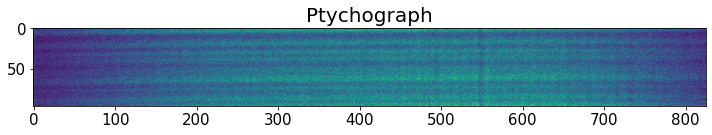

In [178]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(I_n[:, 0])
ax.set_title('Ptychograph', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
plt.show()
# plt.savefig('figures/ptycho.pdf')

In [95]:
K = I_n.shape[-1] / (dij_pix[0, 1] - dij_pix[1, 1])
N = I_n.shape[0]
dI0_avg = np.mean(np.gradient(I0_gk[0])**2)
p_var = np.mean(I_n)
u_var = (p_var / N + p_var / N / K) / dI0_avg / np.mean(I_n**2)

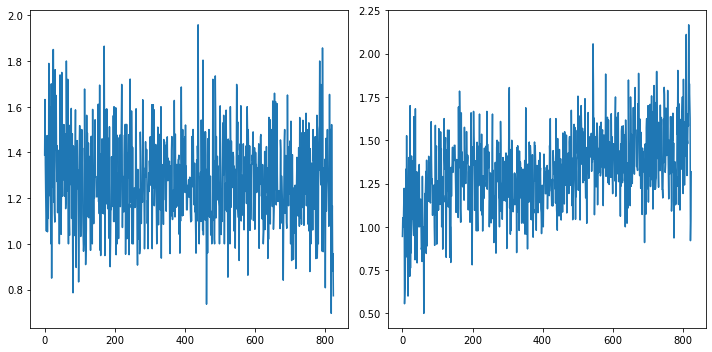

In [179]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(I_n[1, 0] / W[0] )
axes[1].plot(I_n[-1, 0] / W[0])
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
plt.show()
# plt.savefig('figures/ptycho.pdf')

In [180]:
#---------------------------
# Intialise
#---------------------------

# generate pixel map
u, dij_pix, res = st.generate_pixel_map(W.shape, dij, basis, x_ps, y_ps, z, df, verbose=False)
di, dj = pixel_translations(basis, dij, df, z)

# make reference image
I0, n0, m0 = st.make_object_map(I_n, M, W, dij_pix, u, subpixel=True)

I0_gk, di, dj = make_reference(I_n.astype(np.float64), W.astype(np.float64), u, di, dj, ls=8.)

building object map: 100%|██████████| 96/96 [00:00<00:00, 2733.58it/s]


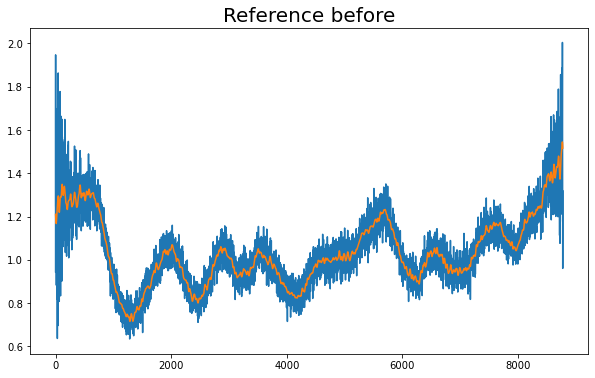

In [181]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(I0[0])
ax.plot(I0_gk[0])
ax.set_title('Reference before', fontsize=20)
plt.show()
# plt.savefig('figures/reference_1595.pdf')

In [182]:
st_res = st_update(I_n, W, dij, basis, x_ps, y_ps, z, df, u_max=400)
ph_res = phase_fit(st_res['u'], (2, I_n.shape[-1] - 2), x_ps, z, df, wl, u_var)

updating object map and translations: 5.38e+01:   0%|          | 0/100 [00:00<?, ?it/s]


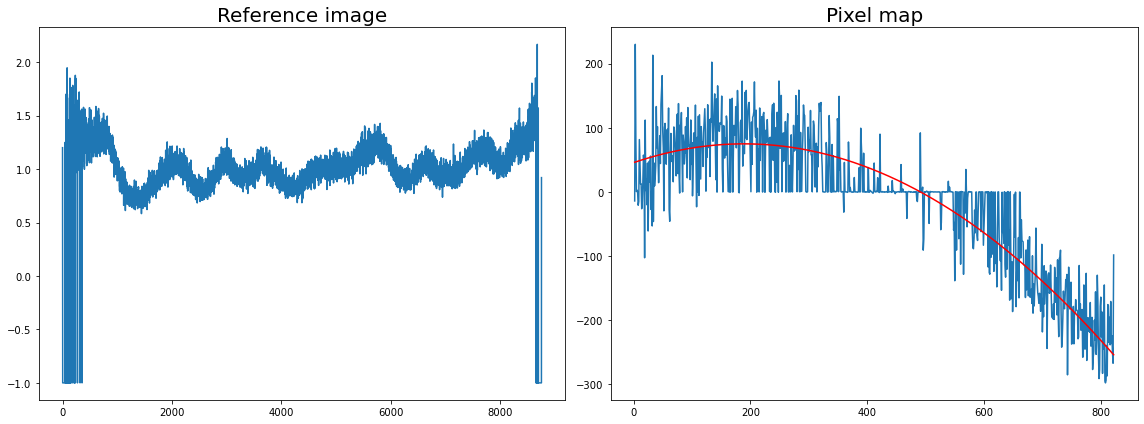

In [183]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(st_res['I0'][0])
axes[0].set_title('Reference image', fontsize=20)
axes[1].plot(ph_res['pix'], ph_res['u_pix'])
axes[1].plot(ph_res['pix'], ab_model(ph_res['pix'], ph_res['fit'].x), color='red')
axes[1].set_title('Pixel map', fontsize=20)
plt.tight_layout()
plt.show()
# plt.savefig('figures/st_results_andrew_1727.pdf')

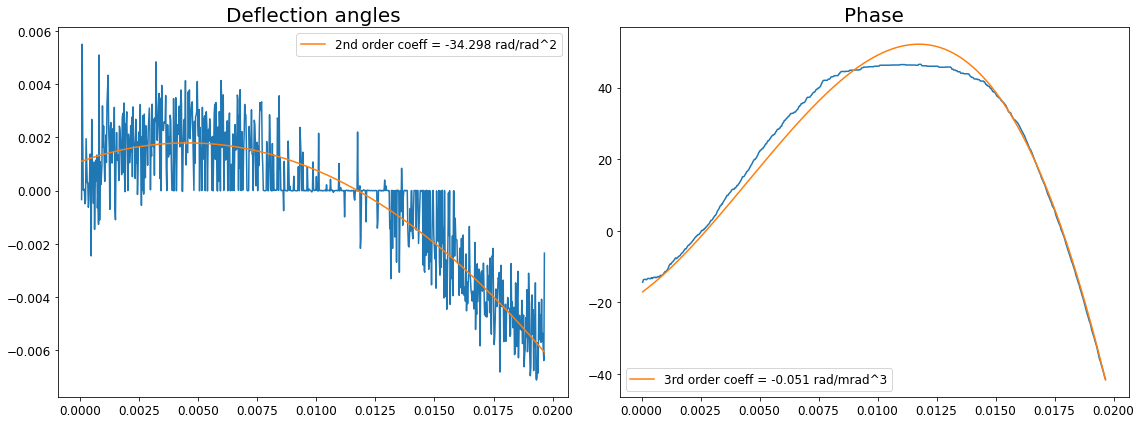

In [184]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(ph_res['theta'], ph_res['angles'])
axes[0].plot(ph_res['theta'], ab_model(ph_res['theta'], ph_res['ang_fit']),
             label='2nd order coeff = {:.3f} rad/rad^2'.format(ph_res['ang_fit'][2]))
axes[0].set_title('Deflection angles', fontsize=20)
axes[1].plot(ph_res['theta'], ph_res['phase'])
axes[1].plot(ph_res['theta'], ph_model(ph_res['theta'], ph_res['ph_fit']),
             label='3rd order coeff = {:.3f} rad/mrad^3'.format(ph_res['ph_fit'][3] * 1e-9))
axes[1].set_title('Phase', fontsize=20)
for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.legend(fontsize=12)
plt.tight_layout()
plt.show()
# plt.savefig('figures/st_fits_andrew_1727.pdf')

In [185]:
str_res = str_update(I_n, W, dij, basis, x_ps, y_ps, z, df, u_max=200, l_scale=2.5)
phr_res = phase_fit(str_res['u'], (2, I_n.shape[-1] - 2), x_ps, z, df, wl, u_var)

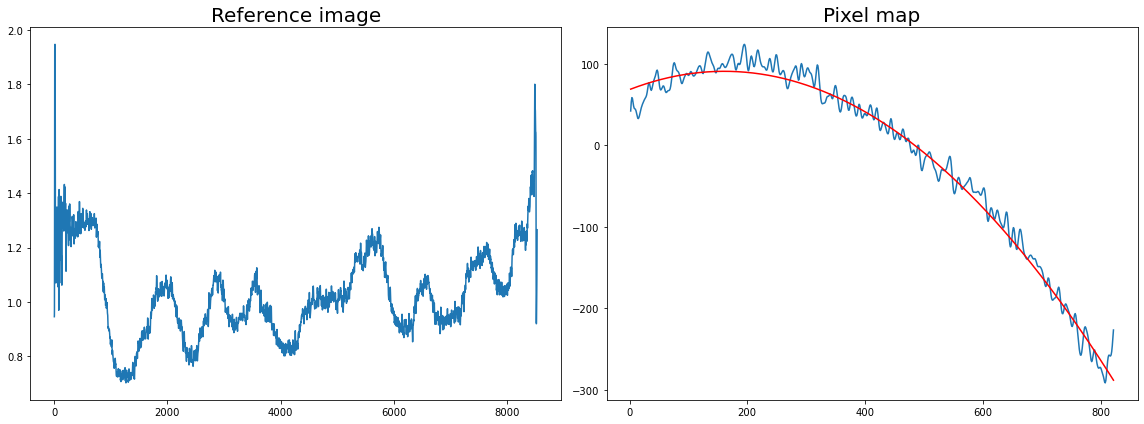

In [186]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(str_res['I0'][0])
axes[0].set_title('Reference image', fontsize=20)
axes[1].plot(phr_res['pix'], phr_res['u_pix'])
axes[1].plot(phr_res['pix'], ab_model(phr_res['pix'], phr_res['fit'].x), color='red')
axes[1].set_title('Pixel map', fontsize=20)
plt.tight_layout()
plt.show()
# plt.savefig('figures/st_results_robust_1727.pdf')

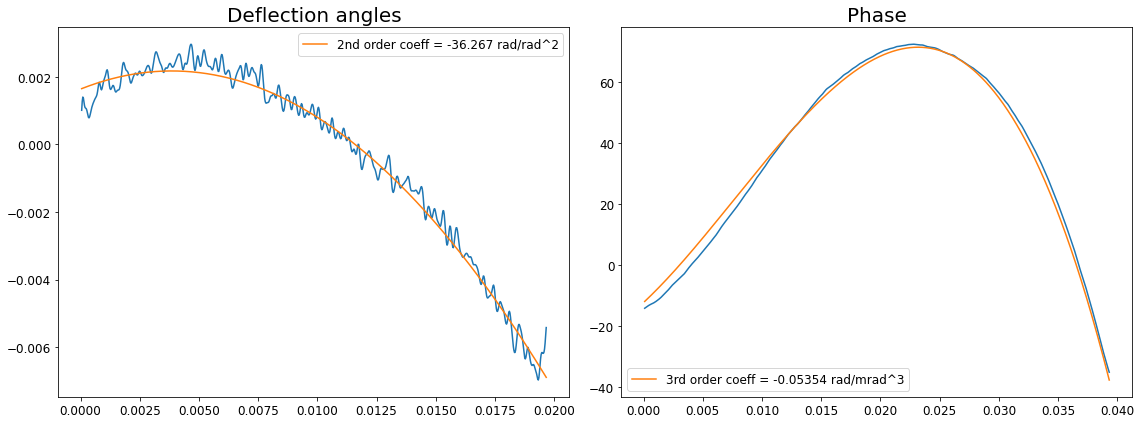

In [187]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(phr_res['theta'], phr_res['angles'])
axes[0].plot(phr_res['theta'], ab_model(phr_res['theta'], phr_res['ang_fit']),
             label='2nd order coeff = {:.3f} rad/rad^2'.format(phr_res['ang_fit'][2]))
axes[0].set_title('Deflection angles', fontsize=20)
axes[1].plot(2 * phr_res['theta'], phr_res['phase'])
axes[1].plot(2 * phr_res['theta'], ph_model(phr_res['theta'], phr_res['ph_fit']),
             label='3rd order coeff = {:.5f} rad/mrad^3'.format(phr_res['ph_fit'][3] * 1e-9))
axes[1].set_title('Phase', fontsize=20)
for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.legend(fontsize=12)
plt.tight_layout()
plt.show()
# plt.savefig('figures/st_fits_robust_1727.pdf')

In [84]:
df_arr = np.linspace(1e-5, 1e-4, 20)
dI0_arr = []
for df in df_arr:
    u, dij_pix, res = st.generate_pixel_map(W.shape, dij, basis, x_ps, y_ps, z, df, verbose=False)
    di = np.ascontiguousarray(dij_pix[:, 0])
    dj = np.ascontiguousarray(dij_pix[:, 1])
    I0_gk, di, dj = make_reference(I_n.astype(np.float), W.astype(np.float), u, di, dj, 100)
    dI0_arr.append(np.mean(np.gradient(I0_gk[0])**2))

In [85]:
df_arr[np.argmax(dI0_arr)]

7.157894736842105e-05

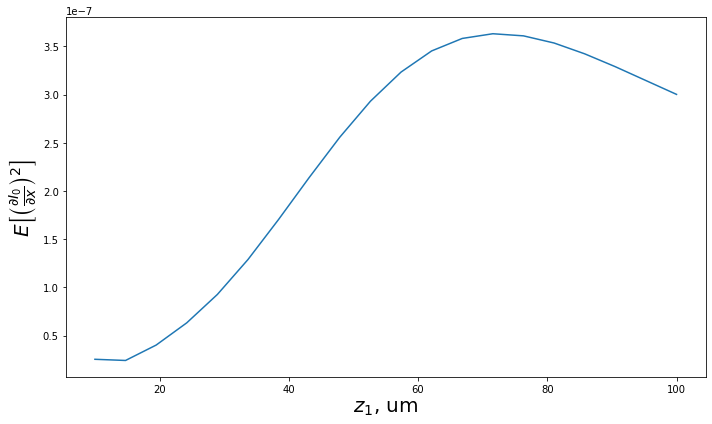

In [87]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df_arr * 1e6, dI0_arr)
ax.set_ylabel(r'$E\left[\left(\frac{\partial I_0}{\partial x}\right)^2\right]$', fontsize=20)
ax.set_xlabel(r'$z_1$, um', fontsize=20)
ax.tick_params(labelsize=10)
plt.tight_layout()
plt.show()
# plt.savefig('figures/defoc_scan_1727.pdf')

In [64]:
K = I_n.shape[-1] / (dij_pix[0, 1] - dij_pix[1, 1])
N = I_n.shape[0]
dI0_avg = np.mean(np.gradient(I0_gk[0])**2)
p_var = np.mean(I_n)
print(np.sqrt((p_var / N + p_var / N / K) / dI0_avg / np.mean(I_n**2)))
# print(np.median((ph_res['u_pix'] - gaussian_filter(ph_res['u_pix'], 20))**2)**0.5)

11.800921341125795


In [152]:
i = 0
sw = np.arange(-400, 400)
mu = int(dij_pix[0, 1] - dij_pix[1, 1])

fs = sw[:, None] + (u[1, 0, i] - dij_pix[:, 1] + m0)[None, :]

mse = np.sum((I_n[:, 0, i] - I0_gk[0, fs.astype(int)] * W[0, i])**2, axis=-1)
dmse = np.gradient(mse)

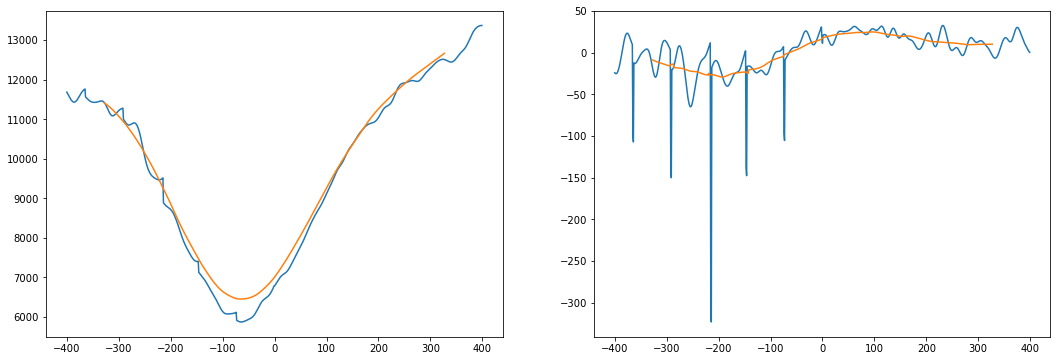

In [153]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
axes[0].plot(sw, mse)
axes[0].plot(sw[mu:-mu], np.cumsum((mse[2 * mu:] - mse[:-2 * mu]) / 2 / mu) + mse[mu])
axes[1].plot(sw, np.gradient(mse))
axes[1].plot(sw[mu:-mu], (mse[2 * mu:] - mse[:-2 * mu]) / 2 / mu)
plt.show()

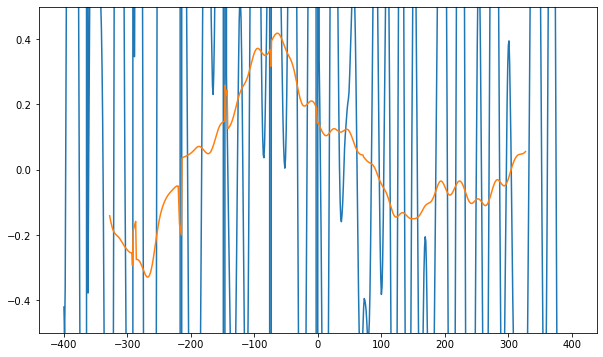

In [154]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(sw, np.gradient(np.gradient(mse)))
ax.plot(sw[mu:-mu], (mse[2 * mu:] + mse[:-2 * mu] - 2 * mse[mu:-mu]) / mu**2)
ax.set_ylim(-0.5, 0.5)
plt.show()

In [56]:
def speckle_tracking(cxi_path, df, roi, u_max=100, n_iter=5):
    with h5py.File(os.path.join(exp_dir, fn_dict[key]), 'r') as cxi_file:
        I_n = cxi_file['/entry_1/data_1/data'][:, roi[0]:roi[1], roi[2]:roi[3]]
        basis = cxi_file['/entry_1/instrument_1/detector_1/basis_vectors'][...]
        z = cxi_file['/entry_1/instrument_1/detector_1/distance'][...]
        x_ps = cxi_file['/entry_1/instrument_1/detector_1/x_pixel_size'][...]
        y_ps = cxi_file['/entry_1/instrument_1/detector_1/y_pixel_size'][...]
        wl = cxi_file['/entry_1/instrument_1/source_1/wavelength'][...]
        dij = cxi_file['/entry_1/sample_1/geometry/translation'][...]

    I_n = I_n[1:-2].astype(np.float32).sum(axis=1)[:, None]
    dij = dij[1:-2]
    basis = basis[1:-2]
    M = np.ones((I_n.shape[1], I_n.shape[2]), dtype=bool)
    W = make_whitefield_st(I_n, M)
    
    res = {'I_var':}
    sigma = np.std(data_st / W)
    

    # generate pixel map
    u_st, dij_pix, _ = st.generate_pixel_map(w_st.shape, dij, basis_st,
                                             x_ps_st, y_ps_st, z_st, df_st, verbose=False)

    # make reference image
    O, n0, m0 = st.make_object_map(data_st, mask_st, w_st, dij_pix, u_st, subpixel=True)
    O = gaussian_filter(O, 10)

    errors = []
    for i in range(max_iter):

        # calculate errors
        error_total = st.calc_error(data_st, mask_st, w_st, dij_pix, O, u_st,
                                    n0, m0, subpixel=True, verbose=False)[0]

        # store total error
        errors.append(error_total / data_st.size)

        # update pixel map
        u_st = st.update_pixel_map(data_st, mask_st, w_st, O, u_st, n0, m0, dij_pix,
                                   search_window=search_window, subpixel=True,
                                   fill_bad_pix=True, integrate=False,
                                   quadratic_refinement=True, verbose=False)[0]

        # make reference image
        O, n0, m0 = st.make_object_map(data_st, mask_st, w_st, dij_pix, u_st,
                                       subpixel=True, verbose=False)

        # update translations
        dij_pix = st.update_translations(data_st, mask_st, w_st, O, u_st, n0, m0, dij_pix)[0]

    # calculate phase
    ur_st = np.array([0, data_st.shape[-1]])
    u_pix = -(u_st[1, 0] - np.arange(u_st.shape[-1]))
    u = u_pix * x_ps_st / z_st
    ph_st = np.cumsum(u) * x_ps_st * df_st / z_st * 2 * np.pi / wl_st
    pix_st = np.arange(roi_st[3] - roi_st[2])[ur_st[0]:ur_st[1]]
    x_st, th_st = pix_st * x_ps_st, pix_st * x_ps_st / z_st

    # fit model to phase
    fit_data = np.stack((pix_st, gaussian_filter(u_pix, 10)), axis=1)
    pix0 = pix_st[np.argmin(fit_data[:, 1])]
    res_u = least_squares(ab_errors, np.array([0, 0, pix0]), args=(fit_data,), xtol=1e-14, ftol=1e-14,
                          bounds=([-np.inf, -np.inf, pix0 - 400], [np.inf, np.inf, pix0 + 400]),
                          loss='cauchy', f_scale=1)
    fit_u = np.array([res_u.x[0] * z_st / x_ps_st,
                      res_u.x[1] * x_ps_st / z_st,
                      res_u.x[2] * x_ps_st / z_st])
    fit_ph = np.array([fit_u[0] * 2 * np.pi / wl_st * df_st / 3,
                       fit_u[1] * 2 * np.pi / wl_st * df_st,
                       ph_st[np.searchsorted(th_st, fit_u[2])], fit_u[2]])

    # evaluating errors
    r_sq = 1 - np.sum(ab_errors(res_u.x, fit_data)**2) / np.sum((fit_data[:, 1] - fit_data[:, 1].mean())**2)
    if np.linalg.det(res_u.jac.T.dot(res_u.jac)):
        cov = np.linalg.inv(res_u.jac.T.dot(res_u.jac))
        dalpha = np.sqrt(cov[0, 0]) * z_st / x_ps_st * 2 * np.pi / wl_st * df_st / 3
    else:
        dalpha = 0

    return {'dev_angle': u, 'phase': ph_st, 'fit': res_u, 'fit_u': fit_u, 'fit_ph': fit_ph, 'pixel_map': u_pix,
            'theta': th_st, 'st_err': np.array(errors), 'r_sq':r_sq, 'dalpha': dalpha, 'ppix': ppix, 'sigma': sigma}

In [57]:
res_dict = {}
p0_arr = np.array([800, 400, 200, 100])
for key in {1595, 1596, 1597, 1598}:
    cxi_path = os.path.join(exp_dir, fn_dict[key])
    res_dict[key] = speckle_tracking(cxi_path, df_dict[key], roi_dict[key],
                                     max_iter=10, phase_roi=(0,-1), search_window=(1, 300))

updating pixel map: 3.01e-01:   0%|          | 0/7 [00:00<?, ?it/s]

Making the whitefield


updating pixel map:   0%|          | 0/7 [00:00<?, ?it/s]

Making the whitefield


updating pixel map: 6.10e-01:   0%|          | 0/7 [00:00<?, ?it/s]

Making the whitefield


updating pixel map: 7.56e-01:   0%|          | 0/7 [00:00<?, ?it/s]

Making the whitefield


updating object map and translations: 4.65e+01:   0%|          | 0/100 [00:00<?, ?it/s]


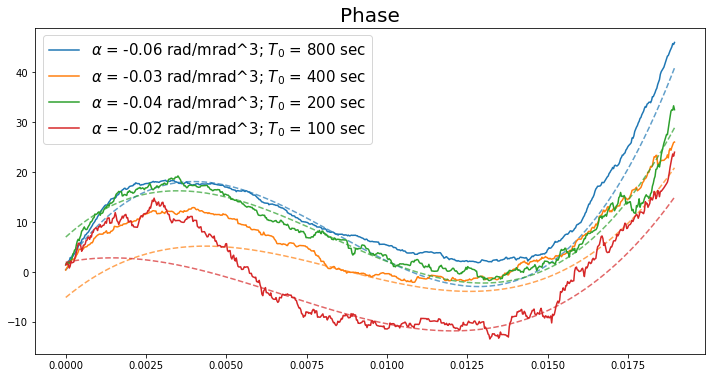

In [83]:
import matplotlib.colors as mcolors

%matplotlib inline
key = 1596
fig, ax = plt.subplots(figsize=(12, 6))
for key, color, p0 in zip([1595, 1596, 1597, 1598], mcolors.TABLEAU_COLORS, p0_arr):
    ax.plot(res_dict[key]['theta'], res_dict[key]['phase'], color=color,
            label=r'$\alpha$ = ' + '{:.2f} rad/mrad^3; '.format(-res_dict[key]['fit_ph'][0] * 1e-9) +
                  r'$T_0$ = ' + '{:d} sec'.format(p0))
    ax.plot(res_dict[key]['theta'], ph_model(res_dict[key]['theta'], res_dict[key]['fit_ph']),
                 color=color, linestyle='dashed', alpha=0.7)
ax.set_title('Phase', fontsize=20)
ax.legend(fontsize=15)
for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=12)
# plt.show()
plt.savefig('figures/phase_etime.pdf')

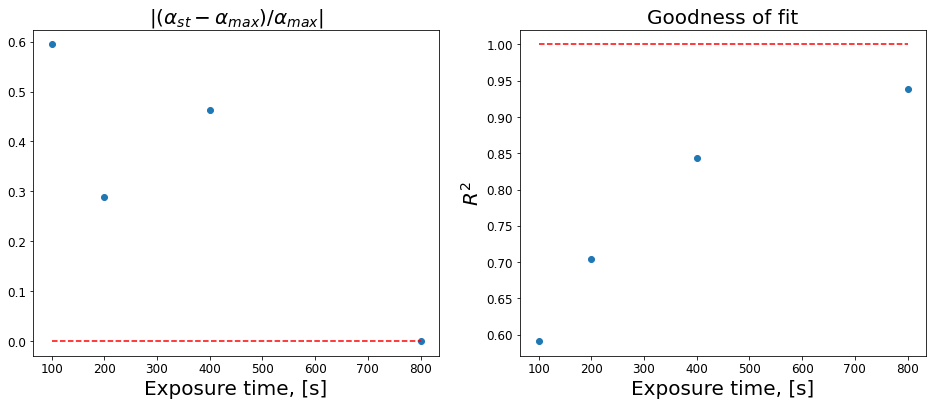

In [81]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
alpha_arr = np.array([res['fit_ph'][0] * 1e-9 for res in res_dict.values()])
r_arr = np.array([res['r_sq'] for res in res_dict.values()])
da_arr = np.abs(alpha_arr - alpha_arr.max()) / alpha_arr.max()
axes[0].scatter(p0_arr, da_arr)
axes[0].plot(np.linspace(p0_arr.min(), p0_arr.max()), np.zeros(50), 'r--')
axes[0].set_title(r'$|(\alpha_{st} - \alpha_{max}) / \alpha_{max}$|', fontsize=20)
axes[1].scatter(p0_arr, r_arr)
axes[1].plot(np.linspace(p0_arr.min(), p0_arr.max()), np.ones(50), 'r--')
axes[1].set_title('Goodness of fit', fontsize=20)
axes[1].set_ylabel(r'$R^2$', fontsize=20)
for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_xlabel('Exposure time, [s]', fontsize=20)
plt.show()
# plt.savefig('figures/fits_etime.pdf')